In [1]:
from sklearn.cluster import DBSCAN, KMeans
from scipy.spatial import distance_matrix
import numpy as np
import pandas as pd
import random
import matplotlib.pyplot as plt
import datetime
from scipy.cluster.vq import kmeans,vq
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import rc_file
#rc_file('/home/p0friedr/okamp/Programme/Python/plotting/plotstyle.rc') 
import argparse
from os import path
import time
import matplotlib.dates as mdates
import seaborn as sns


In [2]:
# load the data
DF = pd.read_csv("NormalisedReturnsSector.csv", index_col = "Date")
#DF = pd.read_csv("Companies1992_2012.csv",
#                index_col="Date")

In [3]:
# first rows are NaNs because of local renormalisation
print(DF.shape)
DF

(5292, 11)


,Utilities,Information Technology,Materials,Health Care,Industrials,Consumer Discretionary,Financials,Communication Services,Consumer Staples,Real Estate,Energy
Date,,,,,,,,,,,
1992-01-02,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1992-01-03,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1992-01-06,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1992-01-07,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1992-01-08,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...
2012-12-24,-13.150235,-15.559262,3.114686,-10.961609,-20.927487,1.176756,-17.361941,-0.710343,-5.359795,1.153713,-14.043977
2012-12-26,-30.880331,-26.606141,-3.296699,-34.500741,-29.367562,-23.170483,-19.964943,-3.401398,-24.458479,-8.267458,-9.148394
2012-12-27,-4.516366,-7.459821,-9.782953,-0.294040,-12.563549,11.888090,-21.559166,-2.265019,1.924305,2.321190,-2.794459


In [4]:
# compute correlation matrices for overlapping, moving intervals
Period = 40 # 2 trading months
Shift = 1
T = int((len(DF) - Period)/Shift)


# because of symmetry and diagonal of 1, only need upper triangle:
Index = np.triu(np.ones((DF.shape[1],
                         DF.shape[1])),1)
print(Index.shape)
print(np.sum(Index))

Index = Index.reshape(1,-1)
Index = Index.astype(bool)
print(Index.shape, np.sum(Index))
CorrMatrices = np.empty((T, np.sum(Index)))
CorrMatricesFull = np.empty((T,int(DF.shape[1]**2.)))

print(len(Index))

for t in range(T):
    #print((0+t*Shift),(Period+t*Shift))
    IntervalDF = DF.iloc[(0+t*Shift):(Period+t*Shift)]
    IntervalCorr = IntervalDF.corr()
    IntervalCorr = IntervalCorr.to_numpy().reshape(1,-1)

    CorrMatricesFull[t,:] = IntervalCorr
    
    # Only save the non-trivial and unique elements of the correlation matrix
    CorrMatrices[t,:] = IntervalCorr[Index]

CorrMatrices.shape   

(11, 11)
55.0
(1, 121) 55
1


(5252, 55)

In [5]:
# Repeated KMeans into 2 clusters

In [6]:
kmean = KMeans(n_clusters = 2,random_state = 12345).fit(CorrMatrices) 


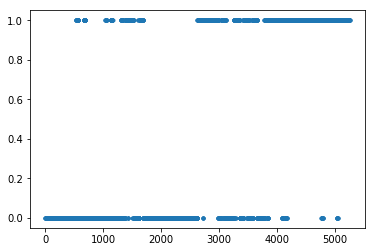

In [7]:
ypred = kmean.predict(CorrMatrices)

plt.plot(ypred,".")

In [8]:
#  now split the initial clusters

CMS0 = CorrMatrices[ypred ==0,:]
CMS1 = CorrMatrices[ypred ==1,:]
print(CMS0.shape,CMS1.shape)

(2857, 55) (2395, 55)


In [9]:
kmean0 = KMeans(n_clusters = 2,random_state = 12345).fit(CMS0) 
ypred0 = kmean0.predict(CMS0)

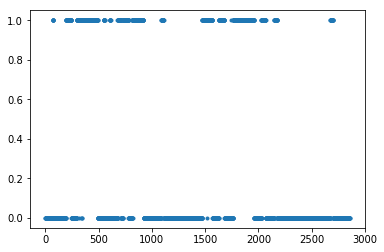

In [10]:
plt.plot(ypred0,".")

In [11]:
#  now split the these sub-clusters
CMS00 = CMS0[ypred0==0,:]
CMS01 = CMS0[ypred0==1,:]
print(CMS00.shape,CMS01.shape)

(1935, 55) (922, 55)


In [12]:
kmean00 = KMeans(n_clusters = 2,random_state = 12345).fit(CMS00) 
ypred00 = kmean00.predict(CMS00)

In [13]:
kmean01 = KMeans(n_clusters = 2,random_state = 12345).fit(CMS01) 
ypred01 = kmean01.predict(CMS01)

In [14]:
# final splits for the first initial cluster
CMS000 = CMS00[ypred00==0,:]
CMS001 = CMS00[ypred00==1,:]
CMS010 = CMS01[ypred01==0,:]
CMS011 = CMS01[ypred01==1,:]
print(CMS000.shape,
     CMS001.shape,
     CMS010.shape,
     CMS011.shape)

(853, 55) (1082, 55) (258, 55) (664, 55)


In [15]:
# Now for the second initial cluster

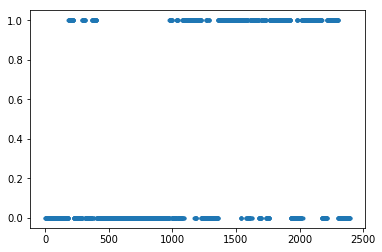

In [16]:
kmean1 = KMeans(n_clusters = 2,random_state = 12345).fit(CMS1) 
ypred1 = kmean1.predict(CMS1)
plt.plot(ypred1,".")

In [17]:
#  now split the these sub-clusters
CMS10 = CMS1[ypred1==0,:]
CMS11 = CMS1[ypred1==1,:]
print(CMS10.shape,CMS11.shape)

(1376, 55) (1019, 55)


In [18]:
kmean10 = KMeans(n_clusters = 2,random_state = 12345).fit(CMS10) 
ypred10 = kmean10.predict(CMS10)
kmean11 = KMeans(n_clusters = 2,random_state = 12345).fit(CMS11) 
ypred11 = kmean11.predict(CMS11)

In [19]:
# final splits for the first initial cluster
CMS100 = CMS10[ypred10==0,:]
CMS101 = CMS10[ypred10==1,:]
CMS110 = CMS11[ypred11==0,:]
CMS111 = CMS11[ypred11==1,:]
print(CMS100.shape,
     CMS101.shape,
     CMS10.shape,
     CMS111.shape)

(417, 55) (959, 55) (1376, 55) (323, 55)


In [20]:
Labels = np.zeros(CorrMatrices.shape[0])

In [21]:
Lab = Labels[0:10]
print(Lab)
Lab  = np.arange(10)
print(Lab)

[0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
[0 1 2 3 4 5 6 7 8 9]


In [22]:
print(Labels[0:20])

[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]


In [23]:
def Label(Instance):
    
    
    Label1 = kmean.predict(Instance.reshape(1, -1))

    if Label1 == 0:
    
        Label2 = kmean0.predict(Instance.reshape(1,-1))
    
        if Label2 == 0:
            Label3 = kmean00.predict(Instance.reshape(1,-1))
    
        elif Label2 == 1:
            Label3 = kmean01.predict(Instance.reshape(1,-1))
    
    
    elif Label1 == 1:
    
        Label2 = kmean1.predict(Instance.reshape(1,-1))
    
        if Label2 == 0:
            Label3 = kmean10.predict(Instance.reshape(1,-1))
    
        elif Label2 == 1:
            Label3 = kmean11.predict(Instance.reshape(1,-1))
    return(str(Label1[0])+str(Label2[0])+str(Label3[0]))
            

In [24]:
Labels = []
for i in range(CorrMatrices.shape[0]):
    Labels.append(Label(CorrMatrices[i,:]))

In [25]:
sum(np.array(Labels)== '101')

959

In [26]:
Labels = np.array(Labels)

In [27]:
Labels[Labels=="000"] = 0
Labels[Labels=="001"] = 1
Labels[Labels=="010"] = 2
Labels[Labels=="011"] = 3
Labels[Labels=="100"] = 4
Labels[Labels=="101"] = 5
Labels[Labels=="110"] = 6
Labels[Labels=="111"] = 7
Labels = Labels.astype(np.int)

/home/users/t_wand01/.local/lib/python3.7/site-packages/ipykernel_launcher.py:9: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  if __name__ == '__main__':


In [28]:
TimeIndex = DF.index[20:(len(DF.index)-20)]

In [29]:
T = [datetime.datetime.strptime(d,'%Y-%m-%d').date() for d in TimeIndex]

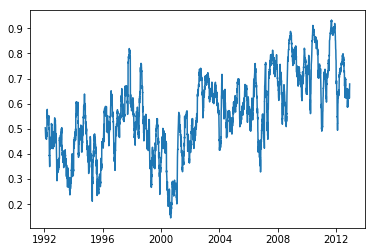

In [30]:
## Now get 1d Time Series

 # We look at the mean correlation value like Stepanov et al. and try to fit a time series to this.

c_bar = CorrMatrices.mean(axis=1)
plt.plot(T,c_bar)
plt.show()
TimeSeries = pd.DataFrame(data = {"t": T,
                                "c_bar": c_bar})
TimeSeries.to_csv("TimeSeries_Finance_Reduced")

In [31]:
print(len(T), len(Labels))

5252 5252


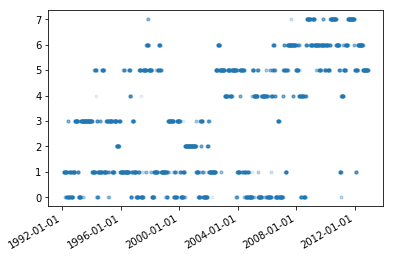

In [32]:
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
plt.gca().xaxis.set_major_locator(mdates.AutoDateLocator())
plt.plot(T,Labels, ".", alpha = 0.1)
#plt.vlines(datetime.date(2001,9,11), "110", "000")
plt.gcf().autofmt_xdate()

In [33]:
np.array(np.unique(Labels, return_counts=True)).T

array([[   0,  853],
       [   1, 1082],
       [   2,  258],
       [   3,  664],
       [   4,  417],
       [   5,  959],
       [   6,  696],
       [   7,  323]])

In [34]:
# Combine all Centroids to one array

Centroids = np.concatenate((kmean00.cluster_centers_,
                            kmean01.cluster_centers_,
                            kmean10.cluster_centers_,
                           kmean11.cluster_centers_))
print(Centroids.shape)
print(Centroids[0].shape)

(8, 55)
(55,)


### Compare this to a true kmeans-approach

And try to sort the labels according to their emergence in data.

In [35]:
KMTrue = KMeans(n_clusters = 8,random_state = 12345).fit(CorrMatrices) 

In [36]:
KMTrue.predict(CorrMatrices)

array([6, 6, 2, ..., 1, 1, 5], dtype=int32)

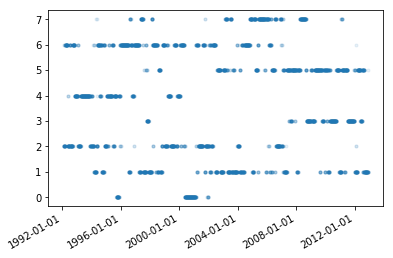

In [37]:
LabelNaive = KMTrue.predict(CorrMatrices)
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
plt.gca().xaxis.set_major_locator(mdates.AutoDateLocator())
plt.plot(T,LabelNaive, ".", alpha = 0.1)
#plt.vlines(datetime.date(2001,9,11), "110", "000")
plt.gcf().autofmt_xdate()

In [38]:
Indexshift = np.zeros(((max(LabelNaive)+1),2)).astype("int") # keep track of which cluster is assigned which number

Indexshift = pd.DataFrame({"Old Label":[],
                          "New Label":[]})
NewLabel = int(0)
for i in range(len(LabelNaive)):
    if (LabelNaive[i] in set(Indexshift["Old Label"]))==False:
        Indexshift = Indexshift.append(pd.DataFrame({"Old Label":[LabelNaive[i]],
                                                      "New Label":[NewLabel]}), ignore_index=True)
        NewLabel = int(NewLabel+1)
print(Indexshift)

   Old Label  New Label
0        6.0        0.0
1        2.0        1.0
2        4.0        2.0
3        1.0        3.0
4        7.0        4.0
5        0.0        5.0
6        5.0        6.0
7        3.0        7.0


In [39]:
LabelNaiveOrdered = np.empty(len(LabelNaive))

for i in range(len(LabelNaive)):
    LabelNaiveOrdered[i] = int(Indexshift.loc[Indexshift["Old Label"]==LabelNaive[i]]["New Label"])

CentroidsNaive = np.zeros((max(LabelNaive)+1, CorrMatrices.shape[1]))

for j in range(max(LabelNaive)+1): # go through the new orering of the clusters
    Old_Order = int(Indexshift.loc[Indexshift["New Label"]==j]["Old Label"])
    CentroidsNaive[j] = KMTrue.cluster_centers_[Old_Order]

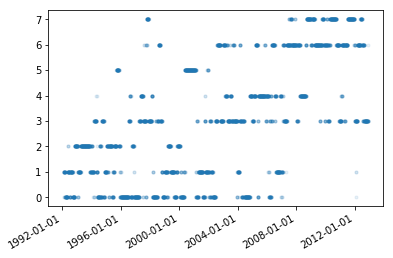

In [40]:
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
plt.gca().xaxis.set_major_locator(mdates.AutoDateLocator())
plt.plot(T,LabelNaiveOrdered,
         ".", alpha = 0.1)
#plt.vlines(datetime.date(2001,9,11), "110", "000")
plt.gcf().autofmt_xdate()

In [41]:
Indexshift["Old Label"][0]

6.0

In [42]:
for i in range(CentroidsNaive.shape[0]):
    print(sum(KMTrue.cluster_centers_[int(Indexshift["Old Label"][i])]  != CentroidsNaive[i]  ))
#print(KMTrue.cluster_centers_[6])

0
0
0
0
0
0
0
0


## Neuralising kmeans

In [43]:
(Centroids**2.).sum(1) - (Centroids[4]**2.).sum()

array([ -8.82644117, -10.27313981, -18.99219187, -16.88254881,
         0.        ,  -1.77901954,   6.49320036,  16.04401217])

In [44]:
w_4 = 2*(Centroids[4] - Centroids)
print(w_4.dot(CorrMatrices.T))

[[  7.55138499   7.55127461   7.24979251 ...  10.10911989  10.05756029
   10.3913169 ]
 [  8.37717166   8.38065164   8.03921911 ...  10.50487543  10.43822637
   10.80000184]
 [ 21.58105257  21.55818387  20.67378523 ...  27.82462898  27.67458656
   28.53626785]
 ...
 [  0.90911623   0.91592154   0.90401526 ...   0.42411466   0.41386201
    0.45244418]
 [ -4.81014833  -4.80236007  -4.60242744 ...  -7.38704022  -7.35513945
   -7.58174172]
 [-10.53423113 -10.52486888 -10.11705528 ... -15.08081055 -15.00575217
  -15.49024989]]


In [45]:
def layer1(x, centroids, i):
    # takes one instance x, centroid-matrix and index of ith centroid
    # returns values for the distances to centroid i
    mu_c = centroids[i]
    w = 2*(mu_c - centroids)
    b = (centroids**2.).sum(1) - (mu_c**2.).sum()
    h = w.dot(x) + b
    return(h)

def layer2(h,i):
    # i is the index of the cluster which we "test" here
    Indices = np.arange(len(h))
    return(min(h[Indices!=i]) )


def DecisionLayer(Minimum):
    return(Minimum > 0)



def NN_k(x,centroids,k):
    # checks if x belongs to kth cluster
    return(layer2(layer1(x,centroids,k),k))

In [46]:
print("First instances Label is", Labels[0])

First instances Label is 1


In [47]:
k = 1451 # some instance

print("Should only be True for Label", Labels[k])

print(" # # # # # #")
for i in range(max(Labels)+1):
    print(i,DecisionLayer(NN_k(CorrMatrices[k,:],Centroids, i)))
    print("# # # # # ")
    
    

Should only be True for Label 6
 # # # # # #
0 False
# # # # # 
1 False
# # # # # 
2 False
# # # # # 
3 False
# # # # # 
4 False
# # # # # 
5 False
# # # # # 
6 True
# # # # # 
7 False
# # # # # 


In [48]:
layer2(layer1(CorrMatrices[0,:],Centroids,1),1)

0.6209119700072497

In [49]:
nKM = max(Labels) + 1 # number of clusters


# CHeck for all instances
Layer_Pred = np.empty(CorrMatrices.shape[0])
Layer_1 = np.empty((CorrMatrices.shape[0], nKM))
Layer_2 = np.empty(CorrMatrices.shape[0])

Counter = 0
for i in range(len(Layer_Pred)): # check all instances
    Counter = 0
    for j in range(nKM): # check all possible clusters
        Decision = DecisionLayer(NN_k(CorrMatrices[i,:],Centroids, j))    
        if Decision:
            Layer_Pred[i] = range(nKM)[j]
            Layer_1[i,:] = layer1(CorrMatrices[i,:], Centroids, j)
            Layer_2[i] = layer2(Layer_1[i,:], j)
            Counter +=1
            
        if Counter > 1:
            print("Problem", i, Labels[i], Layer_Pred[i])
print(sum(Layer_Pred != Labels))


240


In [50]:
print(np.mean(Layer_2))
print(np.mean(Layer_2[Layer_Pred == Labels]))
print(np.mean(Layer_2[Layer_Pred != Labels]))

0.5669543229311493
0.5865195366530903
0.15836744303794656


In [51]:
# Do it again for the naive kmeans




# CHeck for all instances
Layer_Pred2 = np.empty(CorrMatrices.shape[0])

Counter = 0
for i in range(len(Layer_Pred2)): # check all instances
    Counter = 0
    for j in range(nKM): # check all possible clusters
        Decision = DecisionLayer(NN_k(CorrMatrices[i,:],KMTrue.cluster_centers_, j))    
        if Decision:
            Layer_Pred2[i] = range(nKM)[j]
            
            Counter +=1
            
        if Counter > 1:
            print("Problem", i, LabelNaive[i], Layer_Pred2[i])
print(sum(Layer_Pred2 != LabelNaive))
# So this actually works!!!

0


## Analyse what went wrong

Apparently, the neuralisation does not work this way for the bipartite-split kmeans. However, the "regular" kmeans seems to be qualitatively similar, so we might as well continue with that.

In [52]:
WrongL1 = Layer_1[Layer_Pred != Labels].round(1)

Wrong = pd.DataFrame({"Label": Labels[Layer_Pred != Labels],
                     "Predict": Layer_Pred[Layer_Pred != Labels].astype("int")})

for i in range(WrongL1.shape[1]):
    Name = "Cluster "+ str(i)
    Wrong[Name] = WrongL1[:,i]

print(Wrong.iloc[0:50])

    Label  Predict  Cluster 0  Cluster 1  Cluster 2  Cluster 3  Cluster 4  \
0       0        3        0.0        0.2        2.6        0.0        2.8   
1       1        3        0.6        0.0        2.4        0.0        3.3   
2       1        3        0.3        0.1        2.4        0.0        3.1   
3       1        3        0.3        0.0        2.4        0.0        3.1   
4       1        3        0.3        0.1        2.4        0.0        3.1   
5       0        3        0.2        0.5        2.3        0.0        3.3   
6       0        3        0.1        0.4        2.3        0.0        3.1   
7       0        3        0.1        0.5        2.3        0.0        3.1   
8       0        3        0.0        0.5        2.7        0.0        2.8   
9       0        3        0.3        0.6        2.6        0.0        3.1   
10      0        3        0.2        0.4        2.7        0.0        2.9   
11      0        3        0.4        0.5        2.6        0.0        3.2   

In [53]:
print(Layer_1[Layer_Pred != Labels].round(2).shape)
print(np.mean(Layer_1[Layer_Pred != Labels].max(1).round(2)))

print(Layer_1[Layer_Pred == Labels].round(2))
print(np.mean(Layer_1[Layer_Pred == Labels].max(1).round(2)))

(240, 8)
10.453333333333335
[[ 0.62  0.    4.48 ...  1.03  3.58  7.41]
 [ 0.62  0.    4.46 ...  1.03  3.58  7.41]
 [ 0.66  0.    3.92 ...  1.36  4.12  8.16]
 ...
 [ 2.64  1.59 10.19 ...  0.    0.46  2.32]
 [ 2.6   1.53 10.05 ...  0.    0.5   2.4 ]
 [ 2.89  1.85 10.87 ...  0.    0.24  1.88]]
11.504144054269753


#### Problem:

Neuralisation does not always yield the same results as the original clustering. The error quote is about 5%. The reason behind this (see above block) might be that the wrong labels have an output of layer2 that is close to zero, i.e. their classification  not as "clear-cut" 

In [54]:
np.mean(Layer_Pred!=Labels)

0.0456968773800457

In [55]:
Labels[Layer_Pred != Labels] 

array([0, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 5,
       5, 1, 1, 1, 1, 1, 0, 1, 1, 5, 5, 5, 5, 1, 1, 0, 0, 1, 3, 3, 3, 3,
       3, 3, 3, 1, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 2, 2, 2, 3, 3,
       3, 3, 3, 3, 3, 3, 3, 3, 3, 5, 5, 5, 5, 5, 1, 1, 1, 1, 1, 5, 0, 1,
       1, 1, 0, 4, 4, 4, 4, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       5, 5, 5, 5, 5, 5, 5, 3, 3, 3, 3, 3, 3, 3, 3, 5, 4, 1, 1, 1, 5, 5,
       5, 5, 5, 5, 5, 5, 4, 4, 4, 4, 4, 4, 4, 4, 4, 5, 5, 5, 5, 4, 4, 4,
       4, 4, 4, 4, 4, 4, 4, 5, 4, 0, 0, 0, 0, 0, 6, 6, 6, 6, 6, 6, 6, 6,
       5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5,
       5, 1, 0, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5])

In [56]:
Layer_Pred[Layer_Pred != Labels]

array([3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3.,
       3., 3., 3., 3., 5., 5., 5., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3.,
       3., 3., 3., 3., 3., 3., 3., 3., 3., 1., 1., 5., 3., 3., 3., 3., 4.,
       5., 5., 6., 6., 6., 6., 5., 5., 3., 3., 3., 1., 1., 1., 1., 1., 1.,
       1., 5., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 6., 6., 6., 6., 6.,
       5., 5., 5., 5., 5., 6., 5., 5., 5., 5., 5., 6., 6., 6., 6., 5., 4.,
       4., 4., 4., 4., 4., 4., 4., 4., 4., 4., 5., 4., 4., 6., 6., 6., 6.,
       6., 6., 6., 0., 0., 0., 0., 0., 0., 0., 0., 6., 6., 5., 5., 5., 6.,
       6., 6., 6., 6., 6., 6., 6., 6., 6., 6., 6., 6., 6., 6., 6., 6., 6.,
       6., 6., 6., 6., 6., 6., 6., 6., 6., 6., 6., 6., 6., 6., 6., 4., 4.,
       4., 4., 4., 4., 4., 4., 4., 4., 4., 4., 4., 6., 6., 6., 6., 6., 6.,
       6., 6., 6., 6., 6., 6., 6., 6., 6., 6., 6., 6., 6., 6., 6., 6., 6.,
       5., 5., 6., 6., 6.

### LRP Functions

In [57]:
def beta(X, i, DecisionL, NN, Centroids):
    # Takes the Data X, a particular class i, a Decision Layer DecisionL and Neuralised kmeans NN = NN(x,centroids,k)
    # Returns the beta-scaling factor from eq. (3)
    IS_i = np.empty(X.shape[0])
    
    for j in range(X.shape[0]):
        IS_i[j] = DecisionL(NN(X[j,:],
                             Centroids,
                             i))
    return( np.mean(IS_i)**(-1.))
    

In [58]:


def Eq2(X, Centroids, c, beta):
    # take one Data.point X, the cluster Centroids and the cluster of interest c, scaling factor beta
    # output: R_k - array as in equation (2)
    
    n_C = Centroids.shape[0]
    
    H_k = layer1(X, Centroids, c)
    F_c = layer2(H_k, c)
    
    # numerator of eq. (2)
    r_k_func = np.exp(-beta * H_k) * F_c
    
    R_k_out = r_k_func / sum(r_k_func[np.arange(n_C) != c])
    #print(range(n_C), range(n_C) != c)
    return(R_k_out)

In [59]:
def Eq4(X, Centroids, c, beta):

    n_C = Centroids.shape[0]
    Index = (np.arange(n_C) != c) # index of "all clusters except c"
    
    R_previous = Eq2(X, Centroids, c, beta) # from Equation (2)
    R_previous_reduced = R_previous[Index]
    MU_c = Centroids[c]
    M_k = 0.5*(Centroids + MU_c)
    DIFF_x_m = X - M_k
    
    DIFF_x_m_reduced = DIFF_x_m[Index]
    
    W = 2*(MU_c - Centroids)
    W_reduced = W[Index]
    
    Prod = np.multiply(DIFF_x_m_reduced, W_reduced)
    
    R_InputLayer = np.zeros(len(X)) # relevance of each input-feature
    
    for i in range(len(R_InputLayer)):
        for k in range(n_C-1):
            R_InputLayer[i] += Prod[k,i] * R_previous_reduced[k] / np.sum(Prod[k,:])
    
    return(R_InputLayer)

In [60]:

def xai_clust(X, Centroids, X_Label, Dat, DecisionL, Neuralised):

    return(Eq4(X, Centroids,  X_Label,
           beta(Dat, X_Label, DecisionL, Neuralised, Centroids)))


In [61]:
xai_clust(CorrMatrices[0,:], 
          CentroidsNaive, 0, CorrMatrices, 
          DecisionLayer, NN_k).round(1)

array([ 0.1, -0.1,  0.4, -0. ,  0.1, -0.2,  0.1,  0.2, -0.1, -0. , -0. ,
       -0. , -0. , -0.1, -0.3,  0. , -0.1, -0.1,  0.2, -0.2,  0. , -0.2,
        0. ,  0.1, -0.2, -0. ,  0.3, -0.2,  0. ,  0.1,  0. ,  0.2,  0. ,
        0.5, -0. , -0. ,  0. , -0.1, -0. ,  0.2,  0. ,  0.1,  0. ,  0. ,
        0.1,  0. ,  0. ,  0. ,  0.4,  0. ,  0. ,  0. , -0. , -0.1,  0. ])

## Go through entire Data

In [62]:
XAI = np.zeros(CorrMatrices.shape)
LabelNaiveOrdered # is the ordered label output

for i in range(CorrMatrices.shape[0]):
    x = CorrMatrices[i,:]
    XAI[i,:] = xai_clust(x, CentroidsNaive, 
                         LabelNaiveOrdered.astype("int")[i],
                         CorrMatrices, DecisionLayer, NN_k)
print(XAI.round(1))

[[ 0.1 -0.1  0.4 ... -0.  -0.1  0. ]
 [ 0.1 -0.1  0.4 ... -0.  -0.1  0. ]
 [-0.4  1.6 -1.8 ...  0.4  0.7  0.2]
 ...
 [ 0.5  0.8  0.4 ... -0.3 -0.5  0. ]
 [ 0.4  0.6  0.3 ... -0.3 -0.4  0. ]
 [-0.4 -0.8 -0.4 ...  0.4  0.6  0.1]]


In [63]:
for i in range(XAI.shape[1]):
    print(i,np.mean(XAI[:,i]).round(1))

0 0.0
1 -0.2
2 0.1
3 -0.0
4 0.1
5 0.0
6 -0.2
7 0.0
8 -0.0
9 -0.1
10 0.0
11 0.1
12 0.1
13 0.0
14 0.2
15 0.1
16 0.0
17 0.2
18 -0.0
19 -0.1
20 -0.0
21 -0.1
22 -0.1
23 0.0
24 0.0
25 0.0
26 -0.1
27 0.0
28 0.1
29 -0.0
30 -0.1
31 0.0
32 0.0
33 0.2
34 0.0
35 0.0
36 -0.0
37 0.0
38 0.0
39 0.2
40 0.0
41 -0.0
42 0.0
43 -0.0
44 0.2
45 -0.0
46 0.1
47 -0.0
48 0.3
49 -0.0
50 -0.0
51 0.0
52 -0.0
53 0.1
54 -0.1


Cluster 0 with centroid [0.27 0.48 0.47 0.51 0.45 0.54 0.45 0.54 0.34 0.35 0.43 0.56 0.59 0.51
 0.49 0.52 0.41 0.22 0.31 0.6  0.76 0.65 0.64 0.54 0.62 0.4  0.46 0.73
 0.67 0.72 0.6  0.67 0.36 0.42 0.76 0.77 0.65 0.68 0.44 0.46 0.69 0.6
 0.65 0.41 0.37 0.64 0.69 0.43 0.39 0.56 0.31 0.37 0.36 0.39 0.2 ]
And mean importances [-0.06 -1.38  0.5  -0.18  0.44  0.17 -0.99  0.15 -0.31 -0.54  0.2   0.05
  0.22 -0.05  0.71  0.24 -0.09  0.73 -0.03 -0.33 -0.13 -0.55 -0.34  0.12
 -0.02  0.04 -0.33  0.06  0.08 -0.06 -0.37  0.15 -0.03  0.98 -0.05 -0.13
 -0.18  0.23 -0.15  0.88 -0.04 -0.09  0.02 -0.    0.73 -0.1   0.24 -0.06
  1.27 -0.25  0.01  0.3  -0.17  0.12 -0.64]


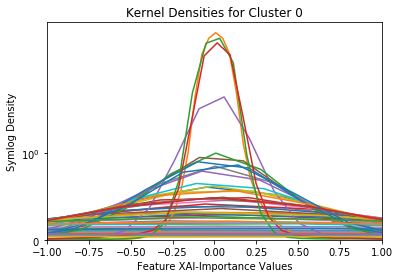

Cluster 1 with centroid [0.24 0.25 0.26 0.29 0.24 0.37 0.28 0.4  0.19 0.24 0.49 0.6  0.68 0.64
 0.62 0.57 0.47 0.36 0.23 0.5  0.73 0.55 0.54 0.44 0.48 0.35 0.31 0.64
 0.63 0.64 0.51 0.6  0.35 0.24 0.74 0.72 0.56 0.55 0.4  0.28 0.68 0.54
 0.59 0.39 0.17 0.58 0.6  0.41 0.19 0.48 0.31 0.21 0.29 0.16 0.08]
And mean importances [ 0.04  0.12  0.02  0.06  0.04  0.01  0.04  0.    0.05  0.01  0.06  0.04
  0.03  0.02  0.05 -0.    0.03  0.08 -0.05  0.06 -0.01  0.03 -0.03  0.03
  0.01  0.   -0.02  0.04  0.04  0.02 -0.03  0.04  0.03 -0.02  0.02 -0.03
  0.03  0.03 -0.01  0.02 -0.01 -0.01 -0.03  0.01  0.01  0.02 -0.   -0.02
 -0.01  0.04  0.03 -0.03 -0.02  0.07  0.04]


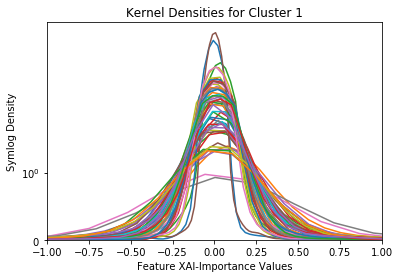

Cluster 2 with centroid [0.19 0.37 0.22 0.38 0.33 0.52 0.32 0.44 0.22 0.2  0.3  0.44 0.43 0.46
 0.4  0.35 0.38 0.1  0.13 0.25 0.63 0.4  0.42 0.28 0.4  0.29 0.31 0.36
 0.46 0.46 0.35 0.57 0.17 0.24 0.52 0.55 0.35 0.45 0.29 0.34 0.57 0.43
 0.56 0.22 0.26 0.43 0.55 0.27 0.27 0.45 0.11 0.1  0.2  0.24 0.11]
And mean importances [ 0.23  0.12 -0.57  0.16 -0.01  0.02  0.12  0.04 -0.05  0.1  -0.07  0.38
  0.13  0.19  0.18  0.27  0.08  0.29 -0.21 -0.3  -0.04  0.02  0.02 -0.17
  0.15  0.21 -0.2   0.11  0.34  0.03  0.03 -0.11  0.18  0.18  0.16  0.43
 -0.07 -0.16  0.3  -0.25  0.16  0.01  0.02 -0.53 -0.    0.09  0.01 -0.27
  0.06 -0.18 -0.27 -0.39  0.01 -0.02  0.04]


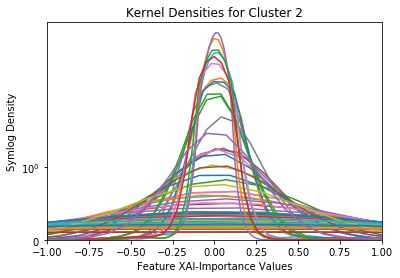

Cluster 3 with centroid [0.41 0.51 0.5  0.52 0.47 0.54 0.52 0.51 0.43 0.46 0.67 0.71 0.78 0.68
 0.7  0.66 0.52 0.45 0.5  0.71 0.84 0.75 0.75 0.66 0.63 0.55 0.62 0.79
 0.71 0.76 0.69 0.65 0.51 0.57 0.84 0.82 0.73 0.66 0.56 0.63 0.77 0.67
 0.64 0.56 0.52 0.72 0.65 0.57 0.59 0.58 0.48 0.53 0.41 0.46 0.4 ]
And mean importances [-0.03 -0.02 -0.03 -0.01  0.   -0.02  0.   -0.02  0.02  0.    0.02 -0.02
  0.01  0.01  0.03 -0.    0.02  0.07  0.02  0.02  0.02  0.03  0.02  0.02
 -0.01  0.03  0.04  0.01  0.01 -0.    0.01 -0.    0.04  0.07  0.01  0.
  0.01 -0.    0.06  0.06  0.    0.01  0.    0.05  0.05  0.02 -0.    0.03
  0.08  0.02  0.06  0.07  0.06  0.03  0.03]


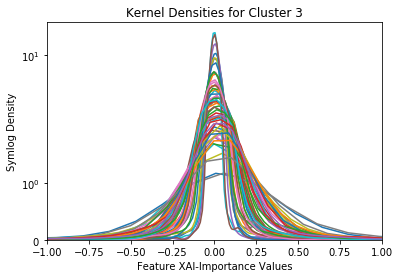

Cluster 4 with centroid [0.46 0.55 0.57 0.59 0.52 0.58 0.52 0.58 0.55 0.41 0.64 0.72 0.77 0.71
 0.69 0.69 0.62 0.58 0.19 0.71 0.82 0.72 0.7  0.6  0.65 0.59 0.41 0.81
 0.75 0.77 0.7  0.74 0.64 0.22 0.83 0.81 0.72 0.76 0.64 0.3  0.79 0.69
 0.75 0.62 0.17 0.73 0.75 0.67 0.21 0.69 0.57 0.18 0.58 0.15 0.23]
And mean importances [-0.06 -0.01 -0.   -0.01  0.01 -0.01 -0.03 -0.    0.07 -0.   -0.03 -0.02
 -0.    0.   -0.02 -0.05  0.03 -0.07  0.15  0.02  0.    0.    0.01 -0.03
 -0.    0.    0.09  0.01  0.02  0.01 -0.    0.02  0.08  0.1   0.01  0.
 -0.01  0.02 -0.01  0.15  0.01 -0.01  0.02  0.03  0.13 -0.02  0.01  0.
  0.09  0.01  0.    0.11  0.03  0.15  0.01]


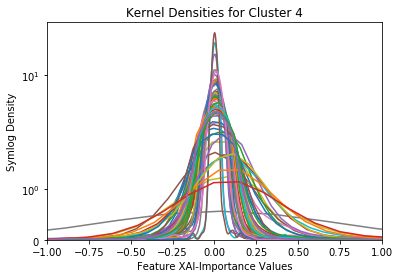

Cluster 5 with centroid [-0.14  0.1   0.1   0.06 -0.04  0.14 -0.01  0.39  0.06  0.27  0.17  0.29
  0.5   0.35  0.38  0.44 -0.09  0.21 -0.03  0.18  0.68  0.54  0.42  0.36
  0.27  0.35  0.19  0.42  0.29  0.4   0.23  0.3   0.25  0.13  0.66  0.62
  0.48  0.22  0.41  0.09  0.51  0.41  0.2   0.34  0.03  0.43  0.24  0.42
  0.06  0.15  0.26  0.03  0.11  0.15  0.06]
And mean importances [ 0.05  0.03  0.02  0.05  0.08  0.09  0.04  0.01  0.01  0.   -0.01  0.04
 -0.02  0.01 -0.01 -0.03  0.18 -0.04  0.02  0.01 -0.    0.   -0.01 -0.
  0.03 -0.    0.01  0.    0.04  0.    0.02  0.1  -0.    0.    0.   -0.01
 -0.02  0.06 -0.    0.02  0.   -0.01  0.1  -0.01  0.01  0.    0.1   0.01
 -0.01  0.03 -0.02  0.02  0.01 -0.   -0.01]


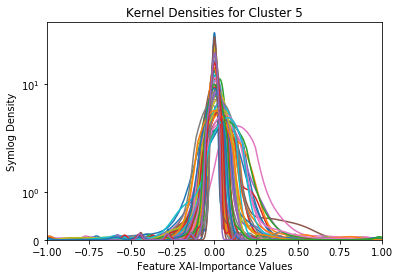

Cluster 6 with centroid [0.6  0.66 0.68 0.68 0.62 0.65 0.66 0.68 0.59 0.62 0.81 0.78 0.86 0.79
 0.77 0.79 0.67 0.63 0.67 0.78 0.9  0.8  0.8  0.76 0.73 0.69 0.76 0.83
 0.76 0.78 0.77 0.78 0.65 0.65 0.86 0.84 0.82 0.75 0.71 0.74 0.79 0.76
 0.72 0.67 0.61 0.77 0.72 0.74 0.64 0.72 0.63 0.65 0.61 0.58 0.56]
And mean importances [ 0.04  0.04  0.05  0.02  0.01  0.04  0.02  0.03  0.04  0.05  0.02  0.01
  0.01  0.02  0.02  0.03  0.    0.03  0.03  0.    0.    0.    0.02  0.02
  0.02  0.01  0.02  0.   -0.    0.01  0.01  0.01  0.02  0.02 -0.    0.01
  0.02  0.    0.02  0.02  0.01  0.01  0.   -0.01  0.02  0.02 -0.    0.04
  0.04  0.02  0.06  0.02 -0.01  0.01  0.06]


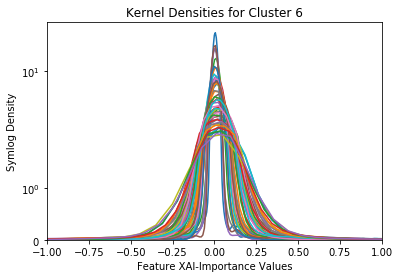

Cluster 7 with centroid [0.75 0.77 0.78 0.78 0.75 0.76 0.8  0.82 0.69 0.8  0.9  0.87 0.93 0.9
 0.87 0.88 0.8  0.8  0.85 0.88 0.95 0.9  0.88 0.87 0.83 0.82 0.89 0.9
 0.86 0.86 0.87 0.85 0.78 0.83 0.93 0.9  0.89 0.84 0.83 0.88 0.88 0.87
 0.83 0.83 0.82 0.86 0.81 0.86 0.82 0.84 0.78 0.84 0.74 0.79 0.75]
And mean importances [ 0.06  0.02  0.03  0.02  0.06  0.02  0.04  0.06 -0.01  0.05  0.01  0.02
  0.01 -0.   -0.01 -0.01  0.07  0.    0.03  0.03  0.    0.02 -0.01  0.
  0.02 -0.02  0.    0.01  0.03  0.02  0.03  0.03  0.    0.05  0.01 -0.
 -0.    0.04 -0.02 -0.    0.02  0.02  0.06  0.05  0.06 -0.    0.05 -0.02
 -0.03  0.04 -0.04  0.04  0.01  0.05 -0.04]


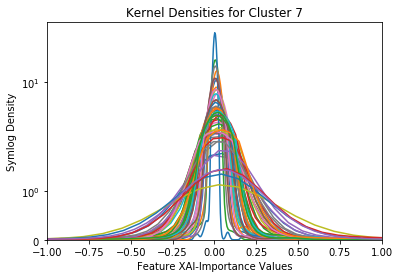

In [64]:
import warnings
warnings.filterwarnings("ignore")

for i in range(nKM):
    print("Cluster", i, "with centroid", CentroidsNaive[i].round(2))
    print("And mean importances", XAI[LabelNaiveOrdered==i,:].mean(0).round(2))
    plt.yscale("symlog", linthresh=1)

    for j in range(min(CorrMatrices.shape[1],100)):
        sns.kdeplot(XAI[LabelNaiveOrdered==i,j], label="Feature " +str(j))
    plt.xlim([-1, 1])
    plt.title("Kernel Densities for Cluster "+str(i))
    plt.ylabel("Symlog Density")
    plt.xlabel("Feature XAI-Importance Values")
    #plt.legend()
    plt.show()

In [65]:
for i in range(nKM):
    print(max(XAI[Labels==i,:].mean(0)))

0.08282646306893779
1.2173695094750607
0.1790611113552201
0.14031140658796185
0.11871258925064679
0.051388671758845074
0.04611306767762683
0.04931971253812805


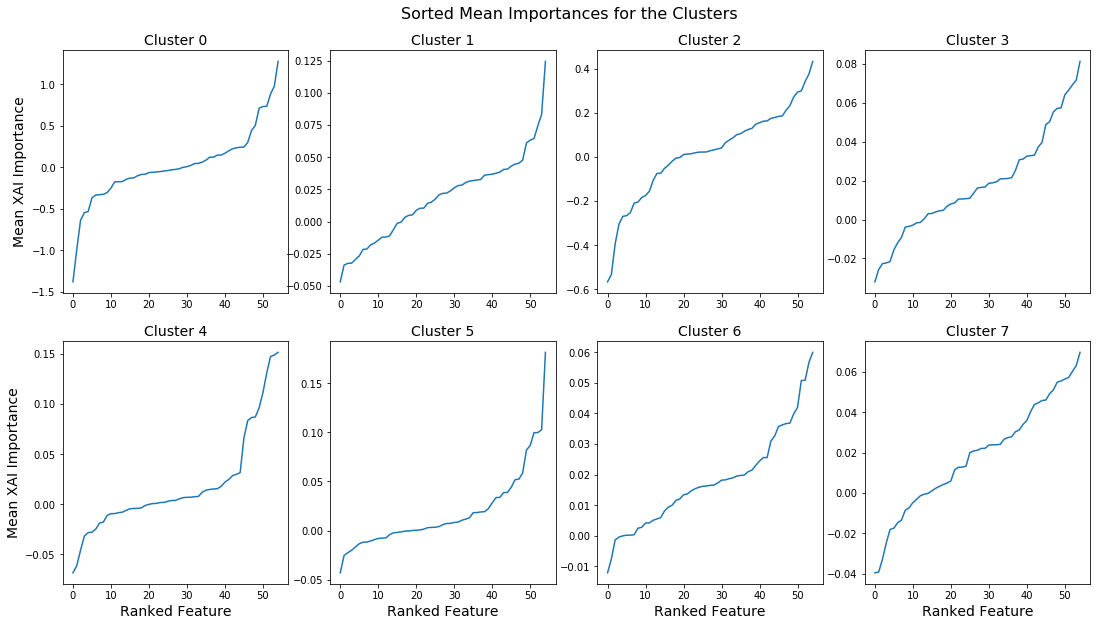

In [66]:
fig, axs = plt.subplots(2, 4,figsize=(15,8))
fig.suptitle("Sorted Mean Importances for the Clusters", fontsize = 16,y=1.05)
fig.tight_layout()
fig.subplots_adjust(hspace=0.2)

axs[0,0].set_ylabel("Mean XAI Importance", fontsize=14)
axs[1,0].set_ylabel("Mean XAI Importance", fontsize=14)

for i in range(4):
    axs[0,i].set_title("Cluster "+ str(i), fontsize=14)
    axs[0,i].plot(np.sort(XAI[LabelNaiveOrdered==i,:].mean(0)))
    axs[1,i].set_xlabel('Ranked Feature', fontsize=14)

for i in range(4):
    axs[1,i].set_title("Cluster "+ str(i+4), fontsize=14)
    axs[1,i].set_xlabel('Ranked Feature', fontsize=14)
    axs[1,i].plot(np.sort(XAI[LabelNaiveOrdered==i+4,:].mean(0)))
plt.show()    

At least for most clusters, one can clearly see an elbow-curve-behaviour at the left and/or right extremes of the feature ranking.

## Now aggregated across all clusters

Text(0.5, 0, 'Sorted Features')

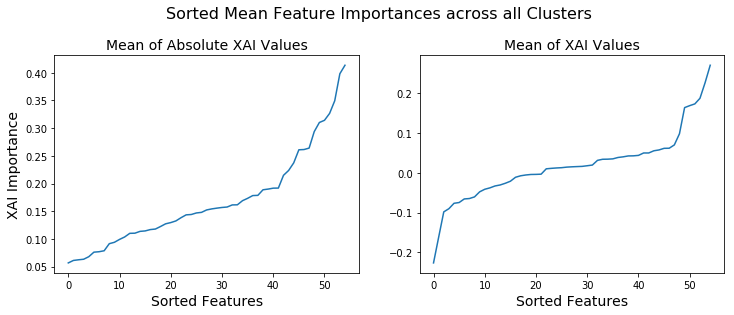

In [67]:
f, ax = plt.subplots( 1,2,figsize=(12,4))
f.suptitle("Sorted Mean Feature Importances across all Clusters", fontsize = 16,y=1.05)

ax[0].set_ylabel("XAI Importance", fontsize=14)

ax[0].set_title("Mean of Absolute XAI Values", fontsize=14)
ax[0].plot(np.sort(abs(XAI).mean(0)))
ax[0].set_xlabel("Sorted Features", fontsize=14)

ax[1].set_title("Mean of XAI Values", fontsize=14)
ax[1].plot(np.sort(XAI.mean(0)))
ax[1].set_xlabel("Sorted Features", fontsize=14)


These are some interesting plots and also show elbow curves. However, I have the suspicion that they might be dominated by the values associated with clusters 0 and (to a lesser degree) 1.

#### The same without Cluster 1

In [68]:
XAI_no01 = XAI[np.logical_and(LabelNaiveOrdered!=0, 
                       LabelNaiveOrdered!=1)]

Text(0.5, 0, 'Sorted Features')

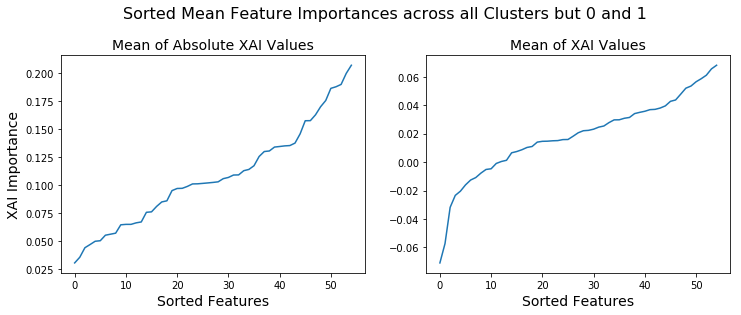

In [69]:
f, ax = plt.subplots( 1,2,figsize=(12,4))
f.suptitle("Sorted Mean Feature Importances across all Clusters but 0 and 1", fontsize = 16,y=1.05)

ax[0].set_ylabel("XAI Importance", fontsize=14)

ax[0].set_title("Mean of Absolute XAI Values", fontsize=14)
ax[0].plot(np.sort(abs(XAI_no01).mean(0)))
ax[0].set_xlabel("Sorted Features", fontsize=14)

ax[1].set_title("Mean of XAI Values", fontsize=14)
ax[1].plot(np.sort(XAI_no01.mean(0)))
ax[1].set_xlabel("Sorted Features", fontsize=14)

Still, there is at least some elbow on the left-hand side